In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from utils import Ngram

## Vector Space

 1. take unigram term-document vectors from n-gram matrix
 2. apply PCA (or UMAP directly?) for dimensionality reduction (original vectors have dimensionality > 10k)
 3. write vectors to .tsv -- also write vector features to file (term, avg pmi?, ...) -> for visualisation in embedding projector
 4. use KDTree (or KMeans?; -> elbow curve) for clusters

In [18]:
NG = Ngram.load("counts", precompute_freqs=True)

tfidf = TfidfTransformer()
ti_mat = tfidf.fit_transform(NG.term_doc_matrix)

None-grams: Term frequencies precomputed...
None-grams: Init done


In [7]:
uni_voc = NG.vocab(1, with_inds=True)

r = len(uni_voc)//3

sub_voc = sorted(np.random.choice(list(uni_voc.keys()), r))
sub_inds = [uni_voc[w] for w in sub_voc]

sub_mat = ti_mat[:, sub_inds].T.toarray()

In [8]:
len(NG.vocab(1)), sub_mat.shape

(27104, (9034, 11199))

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=512)
Y = pca.fit_transform(sub_mat)

In [16]:
from umap import UMAP


umap = UMAP(n_neighbors=15, n_components=512, verbose=100)

In [17]:
Y = umap.fit_transform(sub_mat)
Y.shape

UMAP(dens_frac=0.0, dens_lambda=0.0, n_components=512, verbose=100)
Construct fuzzy simplicial set
Thu Apr  8 00:59:58 2021 Finding Nearest Neighbors
Thu Apr  8 00:59:58 2021 Building RP forest with 10 trees
Thu Apr  8 01:03:00 2021 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	Stopping threshold met -- exiting after 6 iterations
Thu Apr  8 01:03:16 2021 Finished Nearest Neighbor Search
Thu Apr  8 01:03:18 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Apr  8 01:07:22 2021 Finished embedding


(9034, 512)

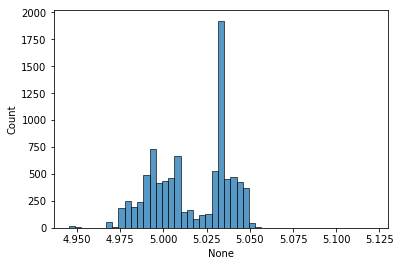

In [26]:
sns.histplot(Y.mean(1))

### Write to TSV

In [27]:
vec_df = pd.DataFrame(Y)

vec_df.to_csv(f"vecs_umap_{len(sub_inds)}.tsv", sep="\t", index=False, header=False)

In [ ]:
v_to_tsv = lambda v: "\t".join(map(str, v))

# fewer_vecs = np.random.permutation(list(vecs.items()))[:5000]

with open(f"vecs_pca_{len(sub_inds)}.tsv", "w") as handle:
    for v in tqdm(Y):
        handle.write(v_to_tsv(v))
        handle.write("\n")

In [54]:
# def get_pmi(w):
#     for w2 in NG.vocab(1):
#         try:
#             yield NG.pmi(w, w2)
#         except ValueError:
#             continue

# avg_pmis = [np.mean(list(get_pmi(w))) for w in tqdm(sub_voc)]


term_freqs = [np.log(NG.freq(w)) for w in sub_voc]

meta_df = pd.DataFrame(dict(term=sub_voc,
                           freq=term_freqs))

meta_df.to_csv(f"meta_umap_{len(sub_inds)}.tsv", sep="\t", index=False, header=True)

# with open(f"meta_umap_{len(sub_inds)}.tsv", "w") as handle:
#     for w in sub_voc:
#         handle.write(str(w)+"\n")

# Semantic Similarity vs PMI 

In [48]:
from numpy.linalg import norm

cos_sim = lambda a, b: np.dot(a, b)/(norm(a)*norm(b))


sub_d = dict(zip(sub_voc, range(len(sub_voc))))


def get_similarity_pmi_pairs():
    for w in tqdm(NG.vocab(2)):
        w1, w2 = w.split()
        if w1 in sub_d and w2 in sub_d:
            cur_pmi = NG.pmi(w1, w2)
            cur_sim = cos_sim(Y[sub_d[w1]], Y[sub_d[w2]])
            yield cur_pmi, cur_sim
            
pmis, sims = list(zip(*get_similarity_pmi_pairs()))
            



  0%|          | 0/108831 [00:00<?, ?it/s]

 29%|██▉       | 31445/108831 [00:00<00:00, 314408.32it/s]

 58%|█████▊    | 63137/108831 [00:00<00:00, 315833.17it/s]

100%|██████████| 108831/108831 [00:00<00:00, 304777.40it/s][A


In [52]:
pmis[:10], sims[:10]

((5.012619578299459,
  2.427657077578301,
  12.988076766192556,
  4.765830729620161,
  4.012619578299459,
  5.012619578299459,
  2.549095943145641,
  6.024042263480429,
  7.210696903580443,
  5.012619578299459),
 (0.99909776,
  0.967997,
  0.9649748,
  0.9990268,
  0.9983124,
  0.99712735,
  0.9675898,
  0.91409177,
  0.98785543,
  0.96803385))

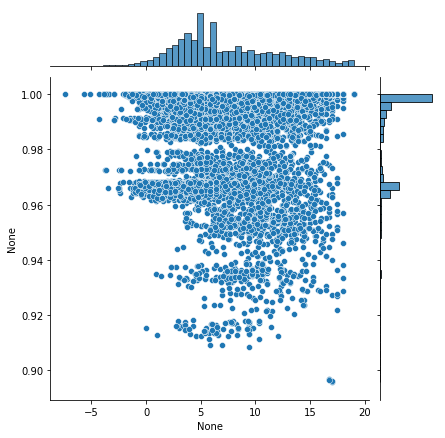

In [53]:
sns.jointplot(x=pmis, y=sims)

## Clusters

In [ ]:
from sklearn.neighbors import KDTree

tree = KDTree(vectors.toarray(), metric="l2")